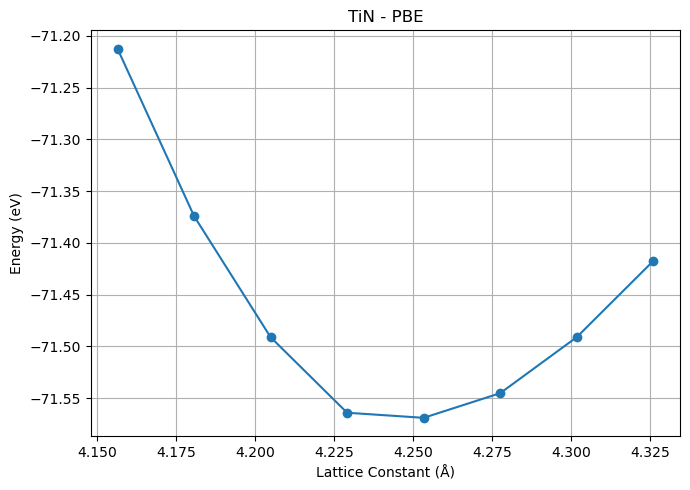

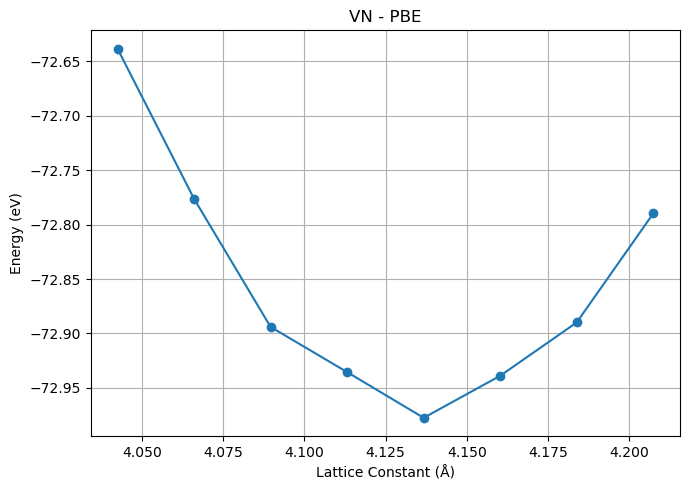

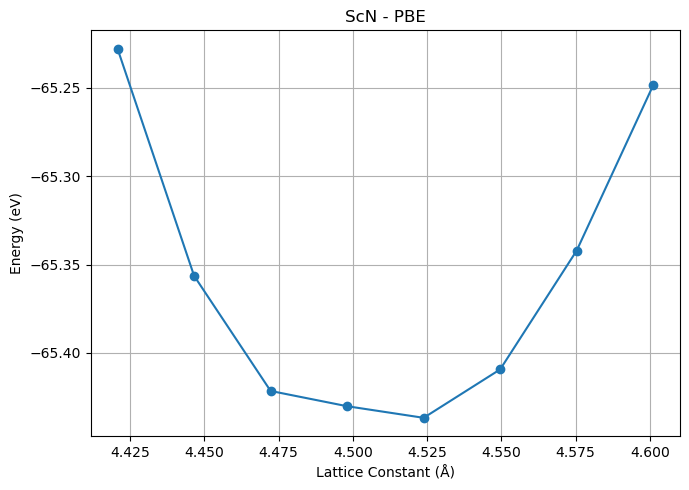

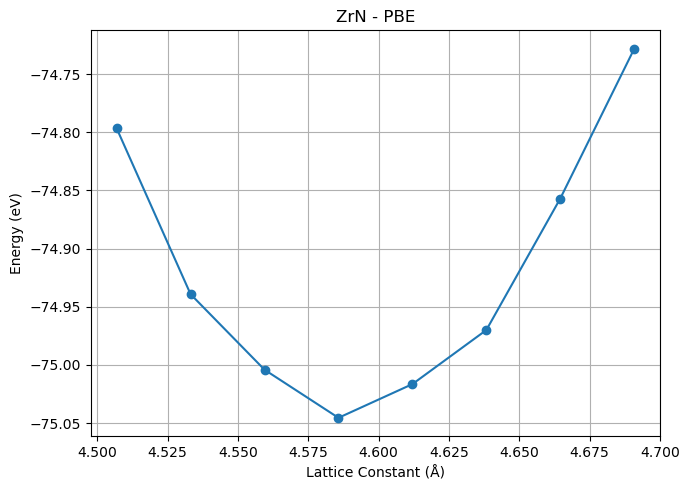

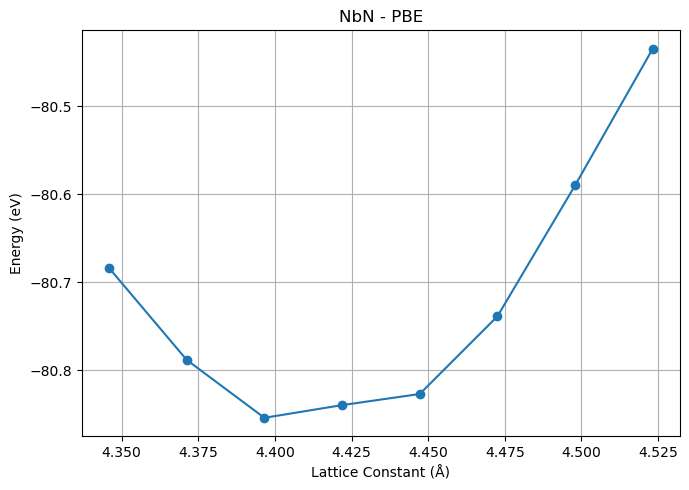

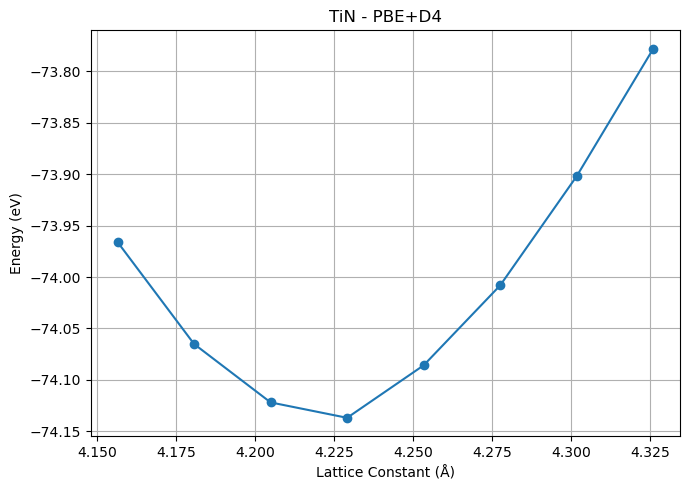

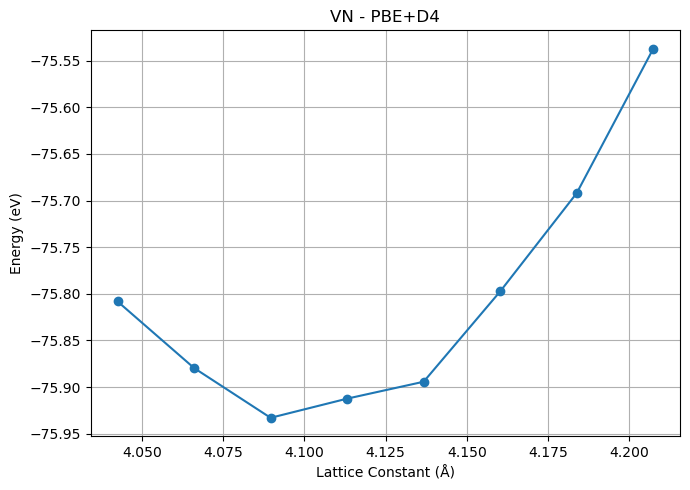

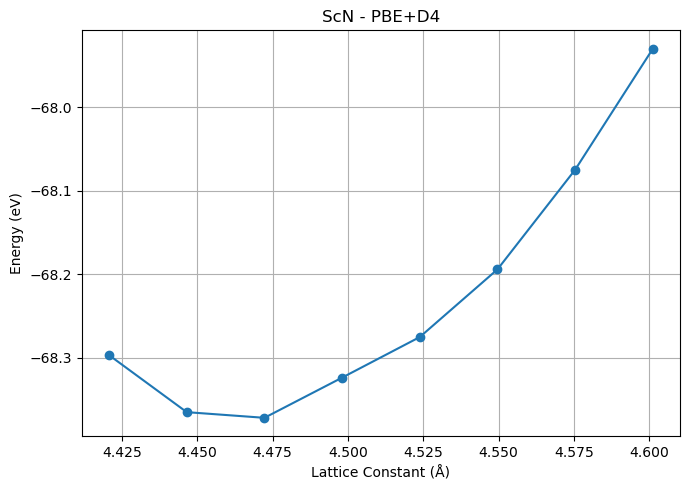

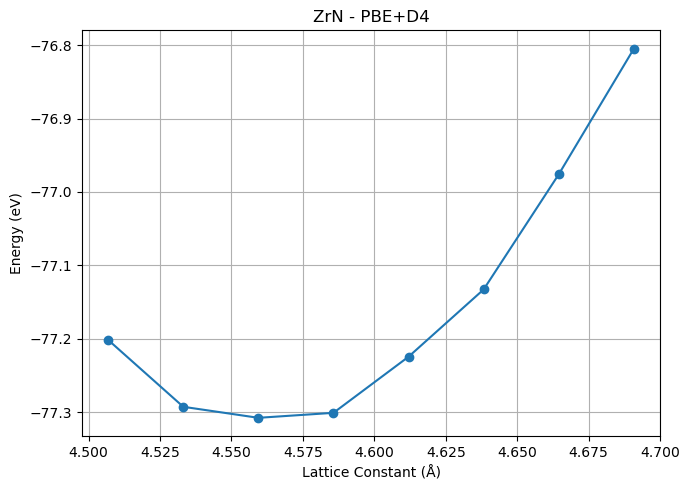

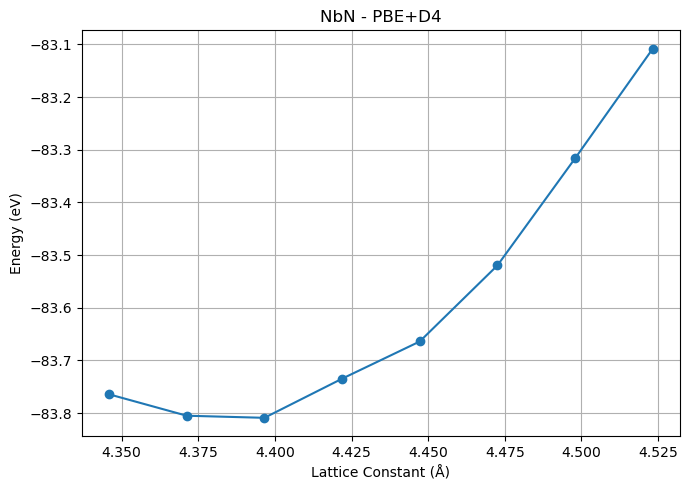

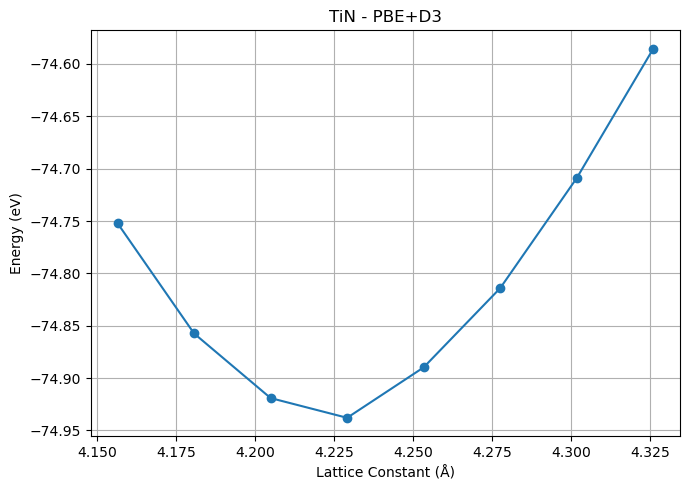

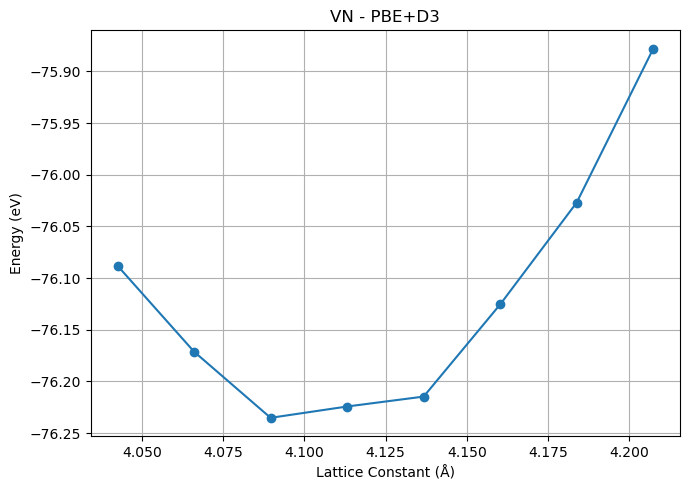

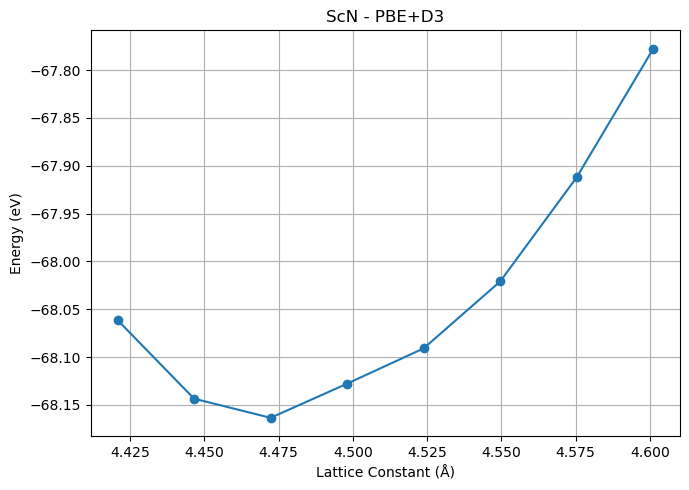

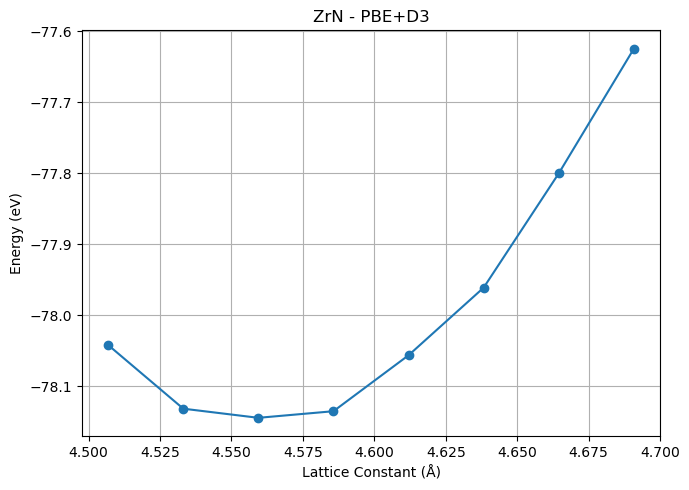

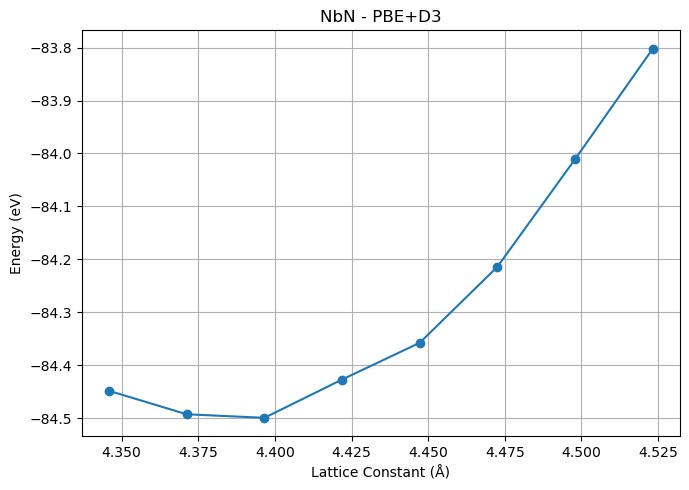

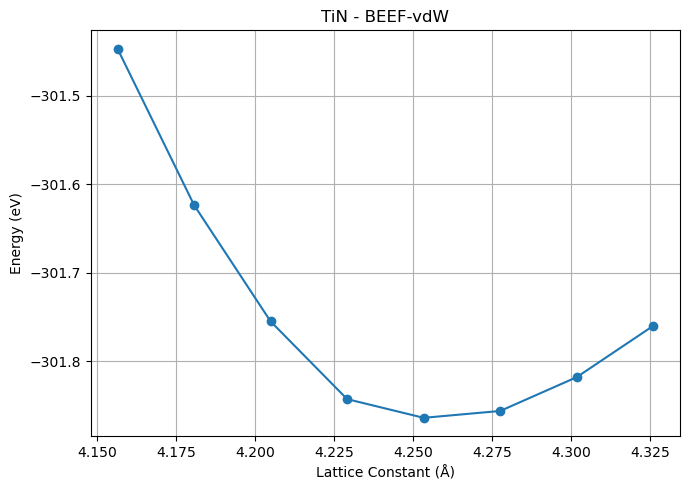

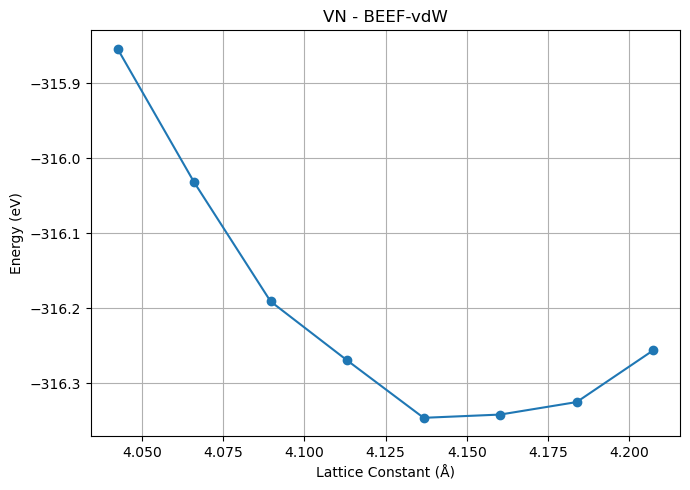

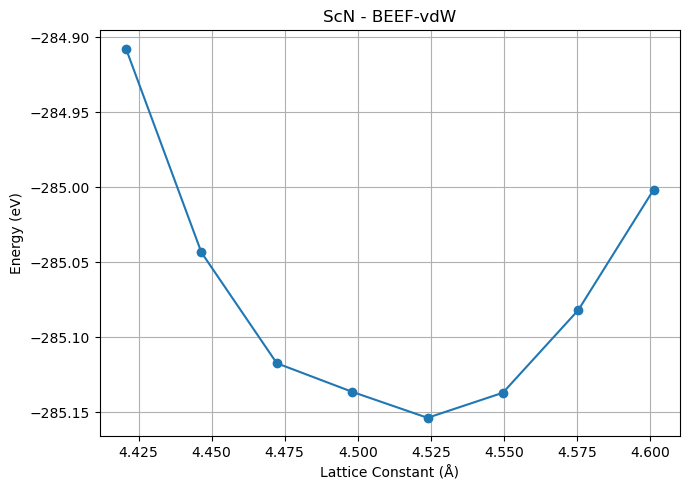

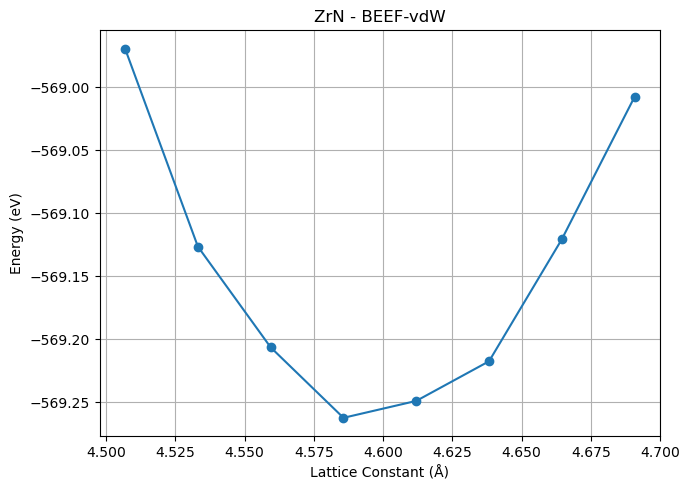

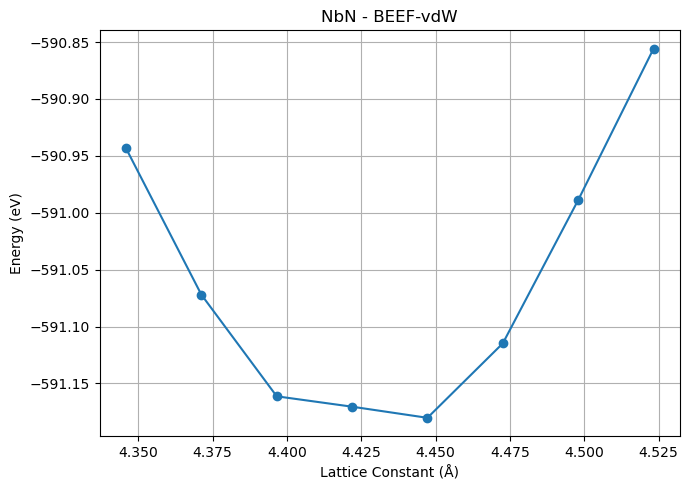

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# List your 4 CSV files here
csv_files = ['pbe_results.csv', 'pbe_d4_results.csv', 'pbe_d3_results.csv', 'beef_vdw_results.csv']

# Read and concatenate all data
dfs = [pd.read_csv(f) for f in csv_files]
data = pd.concat(dfs, ignore_index=True)

# Get unique Material-Functional pairs
mat_func_pairs = data[['Material', 'Functional']].drop_duplicates()

# Plot for each Material and Functional
for _, row in mat_func_pairs.iterrows():
    mat = row['Material']
    func = row['Functional']
    subset = data[(data['Material'] == mat) & (data['Functional'] == func)]

    plt.figure(figsize=(7,5))
    plt.plot(subset['Lattice_Constant'], subset['Energy'], marker='o', linestyle='-')
    plt.xlabel('Lattice Constant (Å)')
    plt.ylabel('Energy (eV)')
    plt.title(f'{mat} - {func}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
